In [3]:
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
import csv
from PIL import Image
from IPython.display import display, Image as IPImage
import os

from pyproj import Transformer
import matplotlib.tri as mtri

%run -i storm_coords.py
%run -i wave_stats.py

In [15]:
# Load the ADCIRC/SWAN bulk stats from the .nc files
data_dir  = "F:/crs/proj/2025_NOPP_comparison/helene_adcirc_model_results/bulk_wave_stats/"
fname_Hs = "allnodes_sig_waveheight_ts_swan_HS_63.nc"
ds_Hs = xr.open_dataset(data_dir+fname_Hs, chunks={"time": 8})

Dir_fname = "allnodes_direction_ts_swan_DIR_63.nc"
ds_Dir = xr.open_dataset(data_dir+Dir_fname, chunks={"time": 8})

Tps_fname = "allnodes_TPSperiod_ts_swan_TPS_63.nc"
ds_Tps = xr.open_dataset(data_dir+Tps_fname, chunks={"time": 8})

# Load the 30-m contour file
contour_file = 'contour30sp.csv'
df = pd.read_csv( contour_file )
contour_latlon = np.column_stack( (df['contour30s_lon'], df['contour30s_lat']) )
normals = np.column_stack( (df['normals30_x'], df['normals30_y']) )
contour_xy = np.column_stack( (df['contour30s_x'], df['contour30s_y']) )

# contour_easting, contour_northing = ...
xp = np.asarray(contour_xy[:,0], dtype=float)
yp = np.asarray(contour_xy[:,1], dtype=float)
print("Number of contour points: ",len(contour_xy))

# Compute distance along contour
dxyc = np.diff(contour_xy, axis=0)
delc = np.linalg.norm( dxyc, axis=1 )
print('Contour spacing (min, max, avg): {:.2f}, {:.2f}, {:.2f} km'.format(np.min(delc)/1000., np.max(delc)/1000., np.mean(delc)/1000. ))
contour_dist = np.hstack((0, np.cumsum( delc )))/1000.
print('Contour length: ',contour_dist[-1], 'km' )

Number of contour points:  425
Contour spacing (min, max, avg): 2.00, 2.00, 2.00 km
Contour length:  848.187204082548 km


In [8]:
# ---- xarray wrappers for my numpy routines ----
def xr_calc_Eflux(Hs_tpc, Tp_tpc, h_pc):
    return xr.apply_ufunc(
        calc_Eflux, Hs_tpc, Tp_tpc, h_pc,
        input_core_dims=[[], [], []],
        output_core_dims=[[]],
        vectorize=True, dask="parallelized", output_dtypes=[np.float32]
    )

def xr_xycoord(mag, ang_deg):
    return xr.apply_ufunc(
        xycoord, mag, ang_deg,
        input_core_dims=[[], []],
        output_core_dims=[[], []],
        vectorize=True, dask="parallelized",
        output_dtypes=[np.float32, np.float32]
    )

def xr_pcoord(x_comp, y_comp):
    return xr.apply_ufunc(
        pcoord, x_comp, y_comp,
        input_core_dims=[[], []],
        output_core_dims=[[], []],
        vectorize=True, dask="parallelized",
        output_dtypes=[np.float32, np.float32]
    )

def circular_mean_deg_tpc(dir_tpc, w_pc):
    # unit vectors from geographic bearings (CW from North): east=sin, north=cos (via your xycoord)
    x_u, y_u = xr_xycoord(xr.zeros_like(dir_tpc)+1.0, dir_tpc)
    x_w = (x_u * w_pc).sum("corner")
    y_w = (y_u * w_pc).sum("corner")
    R = xr.apply_ufunc(np.hypot, x_w, y_w, dask="parallelized", output_dtypes=[np.float32])
    _, mean_dir = xr_pcoord(x_w, y_w)
    return mean_dir.astype("float32"), R.astype("float32")

def weighted_mean_tpc(arr_tpc, w_pc):
    return (arr_tpc * w_pc).sum("corner").astype("float32")

def weighted_rms_tpc(arr_tpc, mean_tp, w_pc):
    return (((arr_tpc - mean_tp)**2 * w_pc).sum("corner")**0.5).astype("float32")

# ---- main builder: subset only vertices referenced by idx_da; no full mesh kept ----
def build_datasets_minmesh(
    ds_Hs, ds_Tps, ds_Dir,
    idx_da, w_da, normals,
    depth_source=None, depth_var="depth",
    crs_out="EPSG:32617",
    keep_offshore=False
):
    """
    Inputs
    ------
    ds_Hs : Dataset with swan_HS(time,node) and coords x(node), y(node) in lon/lat degrees
    ds_Tps: Dataset with swan_TPS(time,node)
    ds_Dir: Dataset with swan_DIR(time,node)  [deg, TOWARDS, geographic]
    idx_da: DataArray (point,corner) of vertex node indices (0-based int)
    w_da  : DataArray (point,corner) barycentric weights (sum=1 per point)
    normals: ndarray (point,2) shoreward unit vectors [east, north]
    depth_source: Dataset/DA holding depth(node); default tries ds_Hs[depth_var]
    crs_out: target projected CRS for x/y (e.g., EPSG:32617 UTM 17N)
    keep_offshore: if False, negative shoreward projections are clipped to 0

    Returns
    -------
    ds_tpc(time, point, corner), ds_tp(time, point)
    """
    # 1) lon/lat at referenced vertices only
    dsh = ds_Hs.rename({"x": "lon", "y": "lat"})
    lon_pc = dsh["lon"].isel(node=idx_da).astype("float32")  # (point,corner)
    lat_pc = dsh["lat"].isel(node=idx_da).astype("float32")

    # 2) transform lon/lat -> projected x/y for ONLY these vertices
    transformer = Transformer.from_crs("EPSG:4326", crs_out, always_xy=True)
    lon_flat = lon_pc.values.reshape(-1)
    lat_flat = lat_pc.values.reshape(-1)
    x_flat, y_flat = transformer.transform(lon_flat, lat_flat)
    x_pc = xr.DataArray(x_flat.reshape(lon_pc.shape), dims=lon_pc.dims, coords=lon_pc.coords).astype("float32")
    y_pc = xr.DataArray(y_flat.reshape(lat_pc.shape), dims=lat_pc.dims, coords=lat_pc.coords).astype("float32")

    # 3) depth at referenced vertices
    if depth_source is None:
        if depth_var in ds_Hs:
            depth_pc = ds_Hs[depth_var].isel(node=idx_da).astype("float32")
        else:
            raise KeyError(f"Depth not found: provide depth_source or ensure '{depth_var}' in ds_Hs.")
    else:
        depth_pc = (depth_source[depth_var] if isinstance(depth_source, xr.Dataset) else depth_source).isel(node=idx_da).astype("float32")

    # 4) time-varying fields at referenced vertices
    Hs_tpc  = ds_Hs["swan_HS"].isel(node=idx_da).astype("float32")
    TPS_tpc = ds_Tps["swan_TPS"].isel(node=idx_da).astype("float32")
    Dir_tpc = ds_Dir["swan_DIR"].isel(node=idx_da).astype("float32")  # deg, towards

    # 5) energy flux at vertices using your NumPy functions
    Eflux_mag_tpc = xr_calc_Eflux(Hs_tpc, TPS_tpc, depth_pc)  # W/m

    # 6) directional components (east, north) and shoreward projection
    Ex_tpc, Ey_tpc = xr_xycoord(Eflux_mag_tpc, Dir_tpc)       # W/m components
    nx = xr.DataArray(normals[:, 0].astype("float32"), dims=("point",))
    ny = xr.DataArray(normals[:, 1].astype("float32"), dims=("point",))

    EfluxS_mag_tpc = (Ex_tpc * nx + Ey_tpc * ny)
    if not keep_offshore:
        EfluxS_mag_tpc = EfluxS_mag_tpc.clip(min=0)
    EfluxS_x_tpc = (EfluxS_mag_tpc * nx).astype("float32")
    EfluxS_y_tpc = (EfluxS_mag_tpc * ny).astype("float32")

    # 7) ds_tpc with ONLY the needed vertices
    ds_tpc = xr.Dataset(
        data_vars=dict(
            Hs_tpc=Hs_tpc, TPS_tpc=TPS_tpc, Dir_tpc=Dir_tpc,
            depth_pc=depth_pc,
            lon_pc=lon_pc, lat_pc=lat_pc, x_pc=x_pc, y_pc=y_pc,
            Eflux_mag_tpc=Eflux_mag_tpc.astype("float32"),
            Eflux_dir_tpc=Dir_tpc,
            Eflux_dirx_tpc=Ex_tpc.astype("float32"),
            Eflux_diry_tpc=Ey_tpc.astype("float32"),
            EfluxS_mag_tpc=EfluxS_mag_tpc.astype("float32"),
            EfluxS_x_tpc=EfluxS_x_tpc, EfluxS_y_tpc=EfluxS_y_tpc,
        ),
        coords=dict(time=Hs_tpc["time"], point=idx_da["point"], corner=idx_da["corner"]),
        attrs=dict(title="Vertex (time,point,corner) fields (subset to triangles around contour points)",
                   notes="lon/lat from ds_Hs (deg); x/y are projected to {crs_out}; directions: towards, CW from North.",
                   conventions="CF-1.8")
    )

    # 8) Reduce to contour points with barycentric weights
    # Scalars (means) and weighted RMS:
    Hs_tp   = weighted_mean_tpc(Hs_tpc,  w_da)
    TPS_tp  = weighted_mean_tpc(TPS_tpc, w_da)
    depth_p = weighted_mean_tpc(depth_pc, w_da)                 # (point,)
    lon_p   = weighted_mean_tpc(lon_pc,   w_da)
    lat_p   = weighted_mean_tpc(lat_pc,   w_da)
    x_p     = weighted_mean_tpc(x_pc,     w_da)
    y_p     = weighted_mean_tpc(y_pc,     w_da)

    Hs_wrms_tp   = weighted_rms_tpc(Hs_tpc,  Hs_tp,  w_da)
    TPS_wrms_tp  = weighted_rms_tpc(TPS_tpc, TPS_tp, w_da)
    depth_wrms_p = weighted_rms_tpc(depth_pc, depth_p, w_da)    # (point,)

    # Directions: circular mean + resultant R
    Dir_tp, Dir_R = circular_mean_deg_tpc(Dir_tpc, w_da)
    # Flux direction shares same angles as Dir_tpc; report separate name for clarity
    Eflux_dir_tp, Eflux_dir_R = Dir_tp, Dir_R

    # Components & magnitudes (linear component means are fine)
    Eflux_dirx_tp = weighted_mean_tpc(Ex_tpc, w_da)
    Eflux_diry_tp = weighted_mean_tpc(Ey_tpc, w_da)
    Eflux_mag_tp  = weighted_mean_tpc(Eflux_mag_tpc, w_da)

    EfluxS_mag_tp = weighted_mean_tpc(EfluxS_mag_tpc, w_da)
    EfluxS_x_tp   = weighted_mean_tpc(EfluxS_x_tpc,   w_da)
    EfluxS_y_tp   = weighted_mean_tpc(EfluxS_y_tpc,   w_da)

    Eflux_mag_wrms_tp  = weighted_rms_tpc(Eflux_mag_tpc,  Eflux_mag_tp,  w_da)
    EfluxS_mag_wrms_tp = weighted_rms_tpc(EfluxS_mag_tpc, EfluxS_mag_tp, w_da)

    ds_tp = xr.Dataset(
        data_vars=dict(
            # scalar means + RMS
            Hs_tp=Hs_tp, TPS_tp=TPS_tp, depth_p=depth_p, lon_p=lon_p, lat_p=lat_p, x_p=x_p, y_p=y_p,
            Hs_wrms_tp=Hs_wrms_tp, TPS_wrms_tp=TPS_wrms_tp, depth_wrms_p=depth_wrms_p,
            # directions (circular mean + resultant R)
            Dir_tp=Dir_tp, Dir_R=Dir_R,
            Eflux_dir_tp=Eflux_dir_tp, Eflux_dir_R=Eflux_dir_R,
            # flux components & magnitudes at points
            Eflux_dirx_tp=Eflux_dirx_tp, Eflux_diry_tp=Eflux_diry_tp, Eflux_mag_tp=Eflux_mag_tp,
            Eflux_mag_wrms_tp=Eflux_mag_wrms_tp,
            EfluxS_mag_tp=EfluxS_mag_tp, EfluxS_x_tp=EfluxS_x_tp, EfluxS_y_tp=EfluxS_y_tp,
            EfluxS_mag_wrms_tp=EfluxS_mag_wrms_tp,
        ),
        coords=dict(time=Hs_tpc["time"], point=idx_da["point"]),
        attrs=dict(title="Contour-point (time,point) fields via barycentric interpolation",
                   notes=("Directions use circular mean; Dir_R/Eflux_dir_R are resultant lengths (0..1). "
                          "RMS variables are weighted RMS across triangle vertices."),
                   conventions="CF-1.8")
    )

    return ds_tpc, ds_tp


In [9]:
# x and y are actually lon/lat...rename for convenience
ds_lonlat = ds_Hs.rename({"x": "lon", "y": "lat"})

lon_all = ds_lonlat["lon"].values  # (node,)
lat_all = ds_lonlat["lat"].values  # (node,)

transformer = Transformer.from_crs("EPSG:4326", "EPSG:32617", always_xy=True)
x_all, y_all = transformer.transform(lon_all, lat_all)  # arrays length = nnode

# Build triangulation from ADCIRC connectivity and locate triangles
# element is usually 1-based in ADCIRC; convert to 0-based
triangles = ds_Hs["element"].values.astype(np.int64) - 1   # (nfaces, 3)

tri = mtri.Triangulation(x_all, y_all, triangles)          # full mesh triangulation
trifinder = tri.get_trifinder()                             # fast point->triangle map
face_idx = trifinder(xp, yp)                                # (npoints,), -1 if outside

# ------------------------------------------------------------
# Extract triangle vertex indices v and barycentric weights w
# ------------------------------------------------------------
bad = np.where(face_idx < 0)[0]
if bad.size:
    # If points fall outside, you can:
    #  - nudge them onto the mesh boundary, or
    #  - switch those specific points to a 3-NN IDW fallback
    # For now, raise to make it explicit:
    raise ValueError(f"{bad.size} contour points fall outside the mesh (indices {bad[:10]}...).")

v = triangles[face_idx, :]         # (npoints, 3) node indices for each enclosing triangle

# barycentric weights for each (xp,yp) in its triangle
x0 = x_all[v[:, 0]]; y0 = y_all[v[:, 0]]
x1 = x_all[v[:, 1]]; y1 = y_all[v[:, 1]]
x2 = x_all[v[:, 2]]; y2 = y_all[v[:, 2]]

den = ( (y1 - y2)*(x0 - x2) + (x2 - x1)*(y0 - y2) )          # (npoints,)
w0  = ( (y1 - y2)*(xp - x2) + (x2 - x1)*(yp - y2) ) / den
w1  = ( (y2 - y0)*(xp - x2) + (x0 - x2)*(yp - y2) ) / den
w2  = 1.0 - w0 - w1
w   = np.stack([w0, w1, w2], axis=1).astype(np.float32)       # (npoints,3)

# Optional sanity checks
# assert np.allclose(w.sum(axis=1), 1.0, atol=1e-6)
# assert (w >= -1e-6).all()  # slight negatives can occur on edges; clip if needed

# ------------------------------------------------------------
# Wrap indices/weights as xarray for labeled broadcasting
# ------------------------------------------------------------
idx_da = xr.DataArray(v.astype(np.int64), dims=("point", "corner"))
w_da   = xr.DataArray(w,                  dims=("point", "corner"))

In [10]:
# ------------------------------------------------------------
# Build datasets using only nearby vertices
# ------------------------------------------------------------
ds_tpc, ds_tp = build_datasets_minmesh(
    ds_Hs=ds_Hs, ds_Tps=ds_Tps, ds_Dir=ds_Dir,
    idx_da=idx_da, w_da=w_da, normals=normals,
    depth_source=ds_Hs, depth_var="depth",
    crs_out="EPSG:32617",
    keep_offshore=False
)

In [17]:
ds_tp

<xarray.Dataset> Size: 12MB
Dimensions:             (time: 431, point: 425)
Coordinates:
  * time                (time) datetime64[ns] 3kB 2022-09-23T12:15:00 ... 202...
  * point               (point) int64 3kB 0 1 2 3 4 5 ... 420 421 422 423 424
Data variables: (12/22)
    Hs_tp               (time, point) float32 733kB dask.array<chunksize=(8, 425), meta=np.ndarray>
    TPS_tp              (time, point) float32 733kB dask.array<chunksize=(8, 425), meta=np.ndarray>
    depth_p             (point) float32 2kB dask.array<chunksize=(425,), meta=np.ndarray>
    lon_p               (point) float32 2kB dask.array<chunksize=(425,), meta=np.ndarray>
    lat_p               (point) float32 2kB dask.array<chunksize=(425,), meta=np.ndarray>
    x_p                 (point) float32 2kB -1.759e+05 -1.739e+05 ... 3.557e+05
    ...                  ...
    Eflux_mag_tp        (time, point) float32 733kB dask.array<chunksize=(8, 425), meta=np.ndarray>
    Eflux_mag_wrms_tp   (time, point) float32 733kB dask.array<chunksize=(8, 425), meta=np.ndarray>
    EfluxS_mag_tp       (time, point) float32 733kB dask.array<chunksize=(8, 425), meta=np.ndarray>
    EfluxS_x_tp         (time, point) float32 733kB dask.array<chunksize=(8, 425), meta=np.ndarray>
    EfluxS_y_tp         (time, point) float32 733kB dask.array<chunksize=(8, 425), meta=np.ndarray>
    EfluxS_mag_wrms_tp  (time, point) float32 733kB dask.array<chunksize=(8, 425), meta=np.ndarray>
Attributes:
    title:        Contour-point (time,point) fields via barycentric interpola...
    notes:        Directions use circular mean; Dir_R/Eflux_dir_R are resulta...
    conventions:  CF-1.8

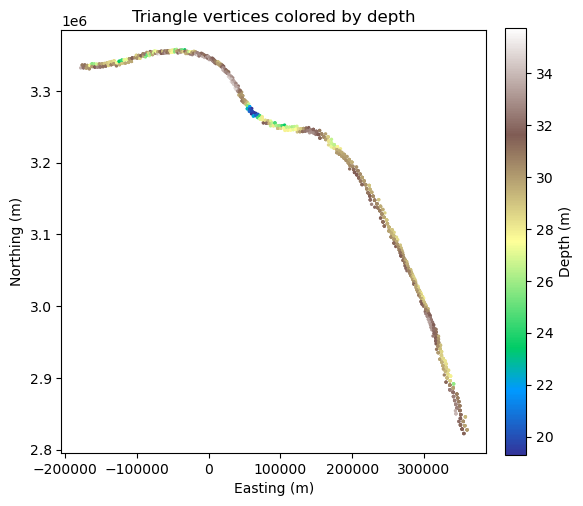

In [12]:
# Pull vertex coordinates (point, corner) and depth
x_pc = ds_tpc["x_pc"]      # (point, corner)
y_pc = ds_tpc["y_pc"]      # (point, corner)
depth_pc = ds_tpc["depth_pc"]  # (point, corner)

# Flatten to 1D for scatter
x_flat = x_pc.values.reshape(-1)
y_flat = y_pc.values.reshape(-1)
c_flat = depth_pc.values.reshape(-1)

plt.figure(figsize=(6,6))
sc = plt.scatter(x_flat, y_flat, s=6, c=c_flat, cmap="terrain", linewidths=0)
plt.gca().set_aspect("equal")
plt.colorbar(sc, fraction=0.046, pad=0.04, label="Depth (m)")
plt.title("Triangle vertices colored by depth")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

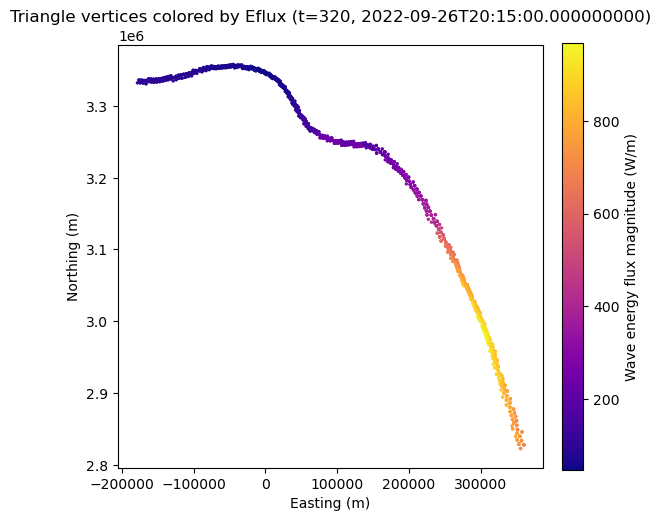

In [13]:
t = 320  # desired time index
nt = ds_tpc.sizes["time"]
if t < 0 or t >= nt:
    raise IndexError(f"time index {t} out of range [0, {nt-1}]")

Eflux_mag_pc = ds_tpc["Eflux_mag_tpc"].isel(time=t)  # (point, corner)

x_flat = ds_tpc["x_pc"].values.reshape(-1)
y_flat = ds_tpc["y_pc"].values.reshape(-1)
c_flat = Eflux_mag_pc.values.reshape(-1)

plt.figure(figsize=(6,6))
sc = plt.scatter(x_flat, y_flat, s=6, c=c_flat, cmap="plasma", linewidths=0)
plt.gca().set_aspect("equal")
cb = plt.colorbar(sc, fraction=0.046, pad=0.04)
cb.set_label("Wave energy flux magnitude (W/m)")
ts = np.datetime_as_string(ds_tpc["time"].values[t])
plt.title(f"Triangle vertices colored by Eflux (t={t}, {ts})")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()


(431, 425)
Total flux integrated over time = 2.524e+13 J


Text(0.5, 0, 'Along-Contour Distance (km)')

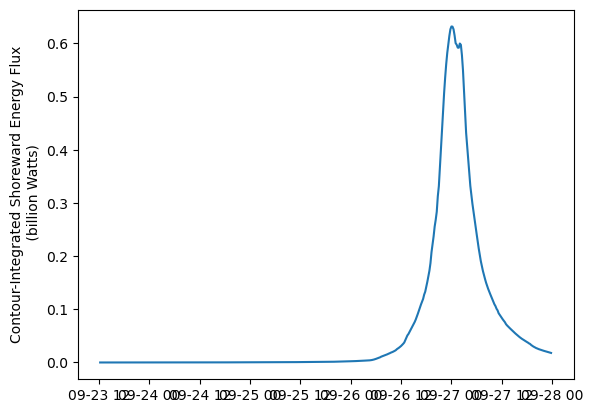

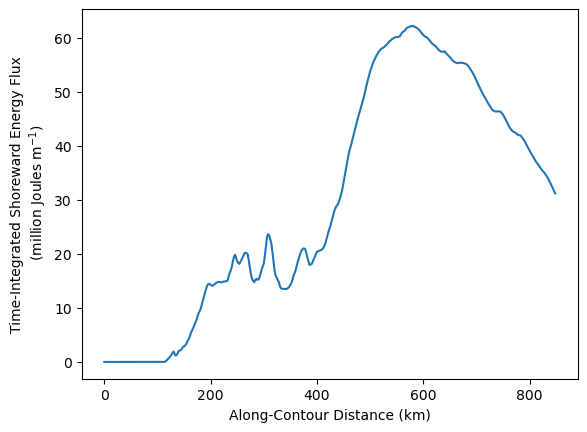

In [28]:
# integrate the total wave energy flux across the contour
from scipy.integrate import trapezoid
x_m = np.asarray(contour_dist) * 1000.0  # km -> m
EfluxS = ds_tp['EfluxS_mag_tp'].values
print(np.shape(EfluxS))

# now integrate over time for the total shoreward flux
EfluxSC = trapezoid(EfluxS, x=x_m, axis=1)     # shape: (ntimes,), units = Watts = Joules/s = kg m^2 s^-3

# Convert times to elapsed seconds relative to start
time = ds_tp['time'].values                  # numpy.datetime64[ns] array
t_sec = (time - time[0]) / np.timedelta64(1, "s")
t_sec = t_sec.astype(float)                  # (ntimes,) in seconds

# also, integrate the shoreward flux over time at each contour point
EfluxST = trapezoid(EfluxS, x=t_sec, axis=0) # Joules meter

# Integrate in time (Watts × seconds → Joules)
EfluxSCT = trapezoid(EfluxSC, x=t_sec)

print(f"Total flux integrated over time = {EfluxSCT:.3e} J")

plt.figure()
plt.plot(time, EfluxSC/1.e9)
plt.ylabel( 'Contour-Integrated Shoreward Energy Flux\n (billion Watts)' )

plt.figure()
plt.plot(contour_dist, EfluxST/1e6)
plt.ylabel( 'Time-Integrated Shoreward Energy Flux\n (million Joules m$^{-1}$)' )
plt.xlabel( 'Along-Contour Distance (km)')

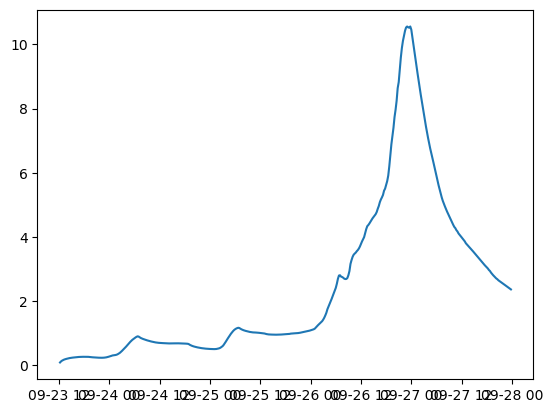

In [30]:
plt.plot(time, ds_tp['Hs_tp'][:,320])